In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/bimcv-padchest-gr-rithvik-edition/BIMCV-Padchest-GR/grounded_reports_20240819.json
/kaggle/input/bimcv-padchest-gr-rithvik-edition/BIMCV-Padchest-GR/master_table.csv/master_table.csv
/kaggle/input/bimcv-padchest-gr-rithvik-edition/BIMCV-Padchest-GR/Padchest_GR_files/PadChest_GR/18170444478498428890131546156984035709_134g5w.png
/kaggle/input/bimcv-padchest-gr-rithvik-edition/BIMCV-Padchest-GR/Padchest_GR_files/PadChest_GR/62906280474335528886711002923566341388_m76jw7.png
/kaggle/input/bimcv-padchest-gr-rithvik-edition/BIMCV-Padchest-GR/Padchest_GR_files/PadChest_GR/173017479468926515377552295687060543889-2_zukli8.png
/kaggle/input/bimcv-padchest-gr-rithvik-edition/BIMCV-Padchest-GR/Padchest_GR_files/PadChest_GR/339855222351391302353935714780946761951_wlpisz.png
/kaggle/input/bimcv-padchest-gr-rithvik-edition/BIMCV-Padchest-GR/Padchest_GR_files/PadChest_GR/65769018201185758078108695660212988067_xi2eq6.png
/kaggle/input/bimcv-padchest-gr-rithvik-edition/BIMCV-Padchest-GR/Pad

In [2]:
# Cell 1: Imports & environment
import os
import random
import math
from collections import Counter, defaultdict
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import itertools
import time
import warnings
warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models import efficientnet_b3, EfficientNet_B3_Weights

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report

# Determinism
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
if torch.cuda.is_available(): torch.cuda.manual_seed_all(SEED)

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


Device: cuda


In [3]:
# Cell 2: Load master_table.csv and show basic info
csv_path = "/kaggle/input/bimcv-padchest-gr-rithvik-edition/BIMCV-Padchest-GR/master_table.csv/master_table.csv"
df = pd.read_csv(csv_path, low_memory=False)

print("Shape:", df.shape)
print("Columns:", df.columns.tolist())
display(df.head(3))

# Use Spanish reports where available; fall back to sentence_en if needed
print("\nSample spanish report (if available):")
if "sentence_es" in df.columns:
    print(df["sentence_es"].dropna().sample(3).values[:3])


Shape: (8787, 23)
Columns: ['StudyID', 'ImageID', 'label', 'boxes_count', 'extra_boxes_count', 'locations', 'prior_study', 'progression_status', 'prior_imageID', 'sentence_en', 'sentence_es', 'study_is_benchmark', 'study_is_validation', 'split', 'PatientID', 'patient_is_benchmark', 'PatientBirth', 'PatientSex_DICOM', 'StudyDate_DICOM', 'StudyDate', 'PatientAge', 'label_group', 'Year']


StudyID                                            ImageID  \
0  2.51488E+38  251488034557732338959601580328898734705_wigcpj...   
1  2.51488E+38  251488034557732338959601580328898734705_wigcpj...   
2  1.09876E+38  109876241481532572619807710001909166420_dln48o...   

                         label  boxes_count  extra_boxes_count  \
0    apical pleural thickening            2                  2   
1  costophrenic angle blunting            0                  0   
2                       Normal            0                  0   

                                           locations  prior_study  \
0                                        ['pleural']        False   
1  ['left costophrenic angle', 'costophrenic angle']        False   
2                                                 []         True   

  progression_status                                      prior_imageID  \
0                NaN                                                NaN   
1                NaN                                                NaN   
2                NaN  216840111366964013217898866992011328080029653_...   

                                         sentence_en  ...  split  \
0               Minimal biapical pleural thickening.  ...   test   
1  Slight blunting of the posterior left costophr...  ...   test   
2                                                NaN  ...  train   

      PatientID  patient_is_benchmark PatientBirth  PatientSex_DICOM  \
0  2.430900e+38                  True         1950                 F   
1  2.430900e+38                  True         1950                 F   
2  2.022000e+38                  True         1947                 M   

   StudyDate_DICOM  StudyDate PatientAge         label_group  Year  
0         20141114       2014         64  pleural thickening  2014  
1         20141114       2014         64    pleural effusion  2014  
2         20140819       2014         67              Normal  2014  

[3 rows x 23 columns]


Sample spanish report (if available):
['Probable relación con componente de derrame pleural bilateral asociado.'
 'Marcapasos bicameral.'
 'Índice cardiotorácico en el límite alto de la normalidad.']


In [4]:
# Cell 3: Build image file lookup from both PadChest folders (robust matching)
base_folder_1 = "/kaggle/input/bimcv-padchest-gr-rithvik-edition/BIMCV-Padchest-GR/Padchest_GR_files/PadChest_GR"
base_folder_2 = "/kaggle/input/bimcv-padchest-gr-rithvik-edition/BIMCV-Padchest-GR/PadChest_GR_progression_prior_studies/PadChest_GR_progression_prior_studies"
folders = [base_folder_1, base_folder_2]

all_files = {}
for folder in folders:
    if os.path.exists(folder):
        for fn in os.listdir(folder):
            all_files[fn] = os.path.join(folder, fn)

print("Total files indexed:", len(all_files))

# The CSV ImageID entries sometimes include '.png' already.
def resolve_image_path(image_id):
    if pd.isna(image_id):
        return None
    s = str(image_id).strip()
    # if it contains path-part, take basename
    base = os.path.basename(s)
    # try direct match
    if base in all_files:
        return all_files[base]
    # try with png
    if (base + ".png") in all_files:
        return all_files[base + ".png"]
    # try replace png with _?.png anomalies: fallback search by startswith
    for k, v in all_files.items():
        if k.startswith(base):
            return v
    # no match
    return None

# Add image_path column
df["image_path"] = df["ImageID"].apply(resolve_image_path)

# Show how many matched
matched = df["image_path"].notna().sum()
print(f"Matched images: {matched} / {len(df)}")
display(df[["ImageID", "image_path"]].head(6))


Total files indexed: 5917
Matched images: 8787 / 8787


ImageID  \
0  251488034557732338959601580328898734705_wigcpj...   
1  251488034557732338959601580328898734705_wigcpj...   
2  109876241481532572619807710001909166420_dln48o...   
3  312447841912476392836878255221324752437_m4dphn...   
4  312447841912476392836878255221324752437_m4dphn...   
5  312447841912476392836878255221324752437_m4dphn...   

                                          image_path  
0  /kaggle/input/bimcv-padchest-gr-rithvik-editio...  
1  /kaggle/input/bimcv-padchest-gr-rithvik-editio...  
2  /kaggle/input/bimcv-padchest-gr-rithvik-editio...  
3  /kaggle/input/bimcv-padchest-gr-rithvik-editio...  
4  /kaggle/input/bimcv-padchest-gr-rithvik-editio...  
5  /kaggle/input/bimcv-padchest-gr-rithvik-editio...

In [5]:
# Cell 4: Filter rows: keep rows with image_path and a Spanish report (or English)
text_col = "sentence_es" if "sentence_es" in df.columns else ("sentence_en" if "sentence_en" in df.columns else None)
assert text_col is not None, "No text column found in CSV."

# Keep rows with image and text
df = df[df["image_path"].notna() & df[text_col].notna()].copy()
df.reset_index(drop=True, inplace=True)
print("Usable rows (image + report):", len(df))

# Normalize labels: lowercase & strip
df["label_norm"] = df["label"].astype(str).str.strip().str.lower()

# Choose top-K labels (most frequent) to avoid singletons causing stratify issues
TOP_K = 20   # <--- change if you want more classes
label_counts = df["label_norm"].value_counts()
top_labels = label_counts.nlargest(TOP_K).index.tolist()
print("Top labels (kept):", top_labels)

# Keep only rows with these labels
df = df[df["label_norm"].isin(top_labels)].reset_index(drop=True)
print("Rows after keeping top-K labels:", len(df))

# Encode labels
le = LabelEncoder()
df["label_encoded"] = le.fit_transform(df["label_norm"])
num_classes = df["label_encoded"].nunique()
print("Number of classes:", num_classes)
print("Label -> idx sample:", dict(zip(le.classes_, le.transform(le.classes_)) ) )


Usable rows (image + report): 7331
Top labels (kept): ['cardiomegaly', 'chronic changes', 'aortic elongation', 'scoliosis', 'vertebral degenerative changes', 'aortic atheromatosis', 'air trapping', 'pleural effusion', 'apical pleural thickening', 'interstitial pattern', 'vascular hilar enlargement', 'costophrenic angle blunting', 'infiltrates', 'laminar atelectasis', 'fibrotic band', 'alveolar pattern', 'increased density', 'callus rib fracture', 'pacemaker', 'pseudonodule']
Rows after keeping top-K labels: 4626
Number of classes: 20
Label -> idx sample: {'air trapping': 0, 'alveolar pattern': 1, 'aortic atheromatosis': 2, 'aortic elongation': 3, 'apical pleural thickening': 4, 'callus rib fracture': 5, 'cardiomegaly': 6, 'chronic changes': 7, 'costophrenic angle blunting': 8, 'fibrotic band': 9, 'increased density': 10, 'infiltrates': 11, 'interstitial pattern': 12, 'laminar atelectasis': 13, 'pacemaker': 14, 'pleural effusion': 15, 'pseudonodule': 16, 'scoliosis': 17, 'vascular hilar

In [6]:
# Cell 5: Train/Validation split (stratify on label_encoded)
train_df, val_df = train_test_split(df, test_size=0.2, random_state=SEED, stratify=df["label_encoded"])
print("Train:", len(train_df), "Val:", len(val_df))


Train: 3700 Val: 926


In [7]:
# Cell 6: Build vocab from training texts and tokenizer (simple whitespace + punctuation split)
from collections import Counter
import re

MAX_VOCAB = 20000
MAX_LEN = 128  # tokens for text sequences

# simple tokenizer
token_pattern = re.compile(r"\w+|[^\w\s]", re.UNICODE)

def simple_tokenize(s):
    return token_pattern.findall(str(s).lower())

# build vocab on train set
counter = Counter()
for txt in train_df[text_col].astype(str).values:
    tokens = simple_tokenize(txt)
    counter.update(tokens)

# reserve special tokens
itos = ["<pad>", "<unk>"] + [tok for tok, _ in counter.most_common(MAX_VOCAB-2)]
stoi = {tok:i for i,tok in enumerate(itos)}
vocab_size = len(itos)
print("Vocab size:", vocab_size)

# encoder function
def encode_text(s, max_len=MAX_LEN):
    toks = simple_tokenize(s)
    ids = [stoi.get(t, stoi["<unk>"]) for t in toks][:max_len]
    if len(ids) < max_len:
        ids = ids + [stoi["<pad>"]] * (max_len - len(ids))
    return ids

# test encoding
print("Example tokens:", simple_tokenize(train_df[text_col].iloc[0])[:20])
print("Example ids:", encode_text(train_df[text_col].iloc[0])[:10])


Vocab size: 932
Example tokens: ['calcificación', 'del', 'cayado', '.']
Example ids: [115, 14, 166, 2, 0, 0, 0, 0, 0, 0]


In [8]:
# Cell 7: PyTorch Dataset and Dataloaders (images + text)
class PadChestDataset(Dataset):
    def __init__(self, df, text_col, transforms=None):
        self.df = df.reset_index(drop=True)
        self.text_col = text_col
        self.transforms = transforms

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        # image
        img_path = row["image_path"]
        img = Image.open(img_path).convert("RGB")
        if self.transforms:
            img = self.transforms(img)
        # text
        text_ids = torch.tensor(encode_text(row[self.text_col]), dtype=torch.long)
        label = torch.tensor(row["label_encoded"], dtype=torch.long)
        return {"image": img, "input_ids": text_ids, "label": label}

# image transforms (EfficientNet expects 300x300)
IMG_SIZE = 300
train_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(5),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])
val_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

BATCH_SIZE = 8  # adjust if memory issues

train_dataset = PadChestDataset(train_df, text_col=text_col, transforms=train_transforms)
val_dataset = PadChestDataset(val_df, text_col=text_col, transforms=val_transforms)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

print("Train batches:", len(train_loader), "Val batches:", len(val_loader))


Train batches: 463 Val batches: 116


In [9]:
# Cell 8: Define Text-only model and Multimodal model
class TextBiLSTM(nn.Module):
    def __init__(self, vocab_size, emb_dim=256, hidden_dim=256, num_layers=1, num_classes=2, dropout=0.3):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, emb_dim, padding_idx=0)
        self.lstm = nn.LSTM(emb_dim, hidden_dim, num_layers=num_layers, batch_first=True, bidirectional=True, dropout=dropout if num_layers>1 else 0.0)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim*2, num_classes)
    def forward(self, input_ids):
        # input_ids: (B, L)
        emb = self.embedding(input_ids)  # (B, L, E)
        out, (hn, cn) = self.lstm(emb)   # out (B,L,2H)
        # take mean pooling over sequence
        pooled = out.mean(dim=1)
        out = self.dropout(pooled)
        logits = self.fc(out)
        return logits

class MultimodalEfficientNet(nn.Module):
    def __init__(self, vocab_size, num_classes, text_emb_dim=256, text_hidden=256, fusion_dropout=0.3, lstm_layers=1):
        super().__init__()
        # image encoder: EfficientNet-B3 pretrained
        self.image_model = efficientnet_b3(weights=EfficientNet_B3_Weights.IMAGENET1K_V1)
        img_feat_dim = self.image_model.classifier[1].in_features
        self.image_model.classifier = nn.Identity()

        # text encoder (same structure as TextBiLSTM)
        self.embedding = nn.Embedding(vocab_size, text_emb_dim, padding_idx=0)
        self.lstm = nn.LSTM(text_emb_dim, text_hidden, num_layers=lstm_layers, batch_first=True, bidirectional=True, dropout=0.0)
        self.text_feat_dim = text_hidden * 2

        # fusion head
        self.fusion = nn.Sequential(
            nn.Linear(img_feat_dim + self.text_feat_dim, 512),
            nn.ReLU(),
            nn.Dropout(fusion_dropout),
            nn.Linear(512, num_classes)
        )

    def forward(self, input_ids, images):
        # images -> image features
        img_feat = self.image_model(images)  # (B, img_feat_dim)

        # text
        emb = self.embedding(input_ids)
        out, _ = self.lstm(emb)  # (B, L, 2H)
        text_feat = out.mean(dim=1)  # (B, 2H)

        # concat
        combined = torch.cat([img_feat, text_feat], dim=1)
        logits = self.fusion(combined)
        return logits

# quick instantiation to confirm shapes
vocab_size = vocab_size  # from Cell 6
print("Vocab size used:", vocab_size)
text_model = TextBiLSTM(vocab_size=vocab_size, emb_dim=128, hidden_dim=128, num_layers=1, num_classes=num_classes).to(device)
mm_model = MultimodalEfficientNet(vocab_size=vocab_size, num_classes=num_classes).to(device)
print("Models instantiated.")


Vocab size used: 932


Downloading: "https://download.pytorch.org/models/efficientnet_b3_rwightman-b3899882.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b3_rwightman-b3899882.pth
100%|██████████| 47.2M/47.2M [00:00<00:00, 182MB/s]


Models instantiated.


In [10]:
# Cell 9: Training utilities (loss, optimizer, scheduler), train and validate loops
import math
from tqdm import tqdm

def train_epoch(model, loader, optimizer, criterion, device):
    model.train()
    losses = []
    all_preds = []
    all_labels = []
    for batch in tqdm(loader, leave=False):
        imgs = batch["image"].to(device)
        input_ids = batch["input_ids"].to(device)
        labels = batch["label"].to(device)

        optimizer.zero_grad()
        # model may accept (input_ids) or (input_ids, images)
        if isinstance(model, TextBiLSTM):
            logits = model(input_ids)
        else:
            logits = model(input_ids, imgs)

        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        losses.append(loss.item())
        preds = logits.argmax(dim=1).detach().cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.detach().cpu().numpy())

    avg_loss = np.mean(losses)
    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average="macro", zero_division=0)
    return avg_loss, acc, f1

def validate_epoch(model, loader, criterion, device):
    model.eval()
    losses = []
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for batch in tqdm(loader, leave=False):
            imgs = batch["image"].to(device)
            input_ids = batch["input_ids"].to(device)
            labels = batch["label"].to(device)

            if isinstance(model, TextBiLSTM):
                logits = model(input_ids)
            else:
                logits = model(input_ids, imgs)

            loss = criterion(logits, labels)
            losses.append(loss.item())

            preds = logits.argmax(dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())

    avg_loss = np.mean(losses)
    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average="macro", zero_division=0)
    return avg_loss, acc, f1, all_labels, all_preds


In [11]:
# Cell 10: Single experiment runner (train model, return history and best checkpoint)
def run_experiment(model, train_loader, val_loader, epochs=10, lr=1e-4, weight_decay=1e-4, model_name="exp"):
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    best_val_f1 = -1
    history = {"train_loss": [], "train_acc": [], "train_f1": [], "val_loss": [], "val_acc": [], "val_f1": []}

    for epoch in range(epochs):
        print(f"\nEpoch {epoch+1}/{epochs} — lr={optimizer.param_groups[0]['lr']}")
        t_loss, t_acc, t_f1 = train_epoch(model, train_loader, optimizer, criterion, device)
        v_loss, v_acc, v_f1, v_labels, v_preds = validate_epoch(model, val_loader, criterion, device)

        print(f"Train loss {t_loss:.4f} acc {t_acc:.4f} f1 {t_f1:.4f}")
        print(f"Val   loss {v_loss:.4f} acc {v_acc:.4f} f1 {v_f1:.4f}")

        history["train_loss"].append(t_loss); history["train_acc"].append(t_acc); history["train_f1"].append(t_f1)
        history["val_loss"].append(v_loss); history["val_acc"].append(v_acc); history["val_f1"].append(v_f1)

        # save best
        if v_f1 > best_val_f1:
            best_val_f1 = v_f1
            torch.save(model.state_dict(), f"{model_name}_best.pth")
            best_ckpt = f"{model_name}_best.pth"

    return history, best_val_f1, best_ckpt


In [12]:
# Cell 11: Smoke test — run 2 epochs for each (text-only and multimodal) to confirm everything works
SMOKE_EPOCHS = 2
print("Running smoke test: Text-only model")
text_model_smoke = TextBiLSTM(vocab_size=vocab_size, emb_dim=128, hidden_dim=128, num_layers=1, num_classes=num_classes).to(device)
hist_text, best_f1_text, ckpt_text = run_experiment(text_model_smoke, train_loader, val_loader, epochs=SMOKE_EPOCHS, lr=1e-3, model_name="text_smoke")

print("\nRunning smoke test: Multimodal model")
mm_model_smoke = MultimodalEfficientNet(vocab_size=vocab_size, num_classes=num_classes).to(device)
hist_mm, best_f1_mm, ckpt_mm = run_experiment(mm_model_smoke, train_loader, val_loader, epochs=SMOKE_EPOCHS, lr=1e-4, model_name="mm_smoke")


Running smoke test: Text-only model

Epoch 1/2 — lr=0.001


Train loss 2.1733 acc 0.3578 f1 0.1995
Val   loss 1.5986 acc 0.4806 f1 0.2131

Epoch 2/2 — lr=0.001


Train loss 1.3406 acc 0.6078 f1 0.3931
Val   loss 1.0753 acc 0.7289 f1 0.5556

Running smoke test: Multimodal model

Epoch 1/2 — lr=0.0001


Train loss 2.5574 acc 0.2338 f1 0.0797
Val   loss 2.2063 acc 0.3499 f1 0.1291

Epoch 2/2 — lr=0.0001


Train loss 2.1019 acc 0.3511 f1 0.1566
Val   loss 1.9566 acc 0.4093 f1 0.1913


In [13]:
# Cell 12: Ablation study setup
# WARNING: This cell will run long if epochs >= 50. Use with caution.
EPOCHS = 15 # set 50 as requested (change if you want shorter runs)
experiments = [
    {"name": "text_baseline_lr1e-3", "model_type": "text", "lr": 1e-3, "dropout": 0.3},
    {"name": "mm_concat_lr1e-4", "model_type": "mm", "lr": 1e-4, "dropout": 0.3},
    {"name": "mm_dropout0.1_lr5e-5", "model_type": "mm", "lr": 5e-5, "dropout": 0.1},
    # add more configs as needed
]

results = {}
for cfg in experiments:
    print("\n=== Running experiment:", cfg["name"])
    if cfg["model_type"] == "text":
        model = TextBiLSTM(vocab_size=vocab_size, emb_dim=128, hidden_dim=128, num_layers=1, num_classes=num_classes, dropout=cfg["dropout"])
    else:
        model = MultimodalEfficientNet(vocab_size=vocab_size, num_classes=num_classes, fusion_dropout=cfg["dropout"])
    hist, best_f1, ckpt = run_experiment(model, train_loader, val_loader, epochs=EPOCHS, lr=cfg["lr"], model_name=cfg["name"])
    results[cfg["name"]] = {"history": hist, "best_f1": best_f1, "ckpt": ckpt}
    print("Finished:", cfg["name"], "best_val_f1:", best_f1)



=== Running experiment: text_baseline_lr1e-3

Epoch 1/15 — lr=0.001


Train loss 1.8496 acc 0.4278 f1 0.2648
Val   loss 1.0744 acc 0.6901 f1 0.4525

Epoch 2/15 — lr=0.001


Train loss 0.8703 acc 0.7441 f1 0.5830
Val   loss 0.6129 acc 0.8218 f1 0.7238

Epoch 3/15 — lr=0.001


Train loss 0.5233 acc 0.8530 f1 0.7642
Val   loss 0.3785 acc 0.8996 f1 0.8173

Epoch 4/15 — lr=0.001


Train loss 0.4140 acc 0.8838 f1 0.8137
Val   loss 0.3648 acc 0.9017 f1 0.8426

Epoch 5/15 — lr=0.001


Train loss 0.3025 acc 0.9165 f1 0.8742
Val   loss 0.2782 acc 0.9147 f1 0.8714

Epoch 6/15 — lr=0.001


Train loss 0.2308 acc 0.9354 f1 0.9037
Val   loss 0.2437 acc 0.9276 f1 0.8957

Epoch 7/15 — lr=0.001


Train loss 0.1946 acc 0.9368 f1 0.9099
Val   loss 0.2375 acc 0.9244 f1 0.8858

Epoch 8/15 — lr=0.001


Train loss 0.1555 acc 0.9519 f1 0.9327
Val   loss 0.2419 acc 0.9341 f1 0.9066

Epoch 9/15 — lr=0.001


Train loss 0.1475 acc 0.9532 f1 0.9362
Val   loss 0.2146 acc 0.9449 f1 0.9233

Epoch 10/15 — lr=0.001


Train loss 0.1264 acc 0.9584 f1 0.9431
Val   loss 0.1968 acc 0.9363 f1 0.9113

Epoch 11/15 — lr=0.001


Train loss 0.1045 acc 0.9635 f1 0.9509
Val   loss 0.2097 acc 0.9438 f1 0.9215

Epoch 12/15 — lr=0.001


Train loss 0.0897 acc 0.9638 f1 0.9521
Val   loss 0.2089 acc 0.9514 f1 0.9334

Epoch 13/15 — lr=0.001


Train loss 0.0855 acc 0.9678 f1 0.9577
Val   loss 0.2041 acc 0.9449 f1 0.9259

Epoch 14/15 — lr=0.001


Train loss 0.0709 acc 0.9700 f1 0.9590
Val   loss 0.2024 acc 0.9525 f1 0.9340

Epoch 15/15 — lr=0.001


Train loss 0.0700 acc 0.9714 f1 0.9621
Val   loss 0.2026 acc 0.9460 f1 0.9279
Finished: text_baseline_lr1e-3 best_val_f1: 0.9339968641520894

=== Running experiment: mm_concat_lr1e-4

Epoch 1/15 — lr=0.0001


Train loss 2.5991 acc 0.2203 f1 0.0705
Val   loss 2.1827 acc 0.3413 f1 0.1184

Epoch 2/15 — lr=0.0001


Train loss 2.0803 acc 0.3611 f1 0.1619
Val   loss 1.9226 acc 0.3942 f1 0.1769

Epoch 3/15 — lr=0.0001


Train loss 1.7020 acc 0.4827 f1 0.2706
Val   loss 1.4727 acc 0.5464 f1 0.3143

Epoch 4/15 — lr=0.0001


Train loss 1.4300 acc 0.5919 f1 0.3828
Val   loss 1.3553 acc 0.6004 f1 0.3810

Epoch 5/15 — lr=0.0001


Train loss 1.2309 acc 0.6451 f1 0.4513
Val   loss 1.1629 acc 0.6566 f1 0.4605

Epoch 6/15 — lr=0.0001


Train loss 1.0847 acc 0.6797 f1 0.4947
Val   loss 1.0523 acc 0.6793 f1 0.4934

Epoch 7/15 — lr=0.0001


Train loss 0.9556 acc 0.7186 f1 0.5518
Val   loss 0.9518 acc 0.7063 f1 0.5278

Epoch 8/15 — lr=0.0001


Train loss 0.8578 acc 0.7508 f1 0.6040
Val   loss 0.8900 acc 0.7441 f1 0.5828

Epoch 9/15 — lr=0.0001


Train loss 0.7728 acc 0.7738 f1 0.6440
Val   loss 0.8152 acc 0.7700 f1 0.6090

Epoch 10/15 — lr=0.0001


Train loss 0.6840 acc 0.7989 f1 0.6736
Val   loss 0.7413 acc 0.7765 f1 0.6400

Epoch 11/15 — lr=0.0001


Train loss 0.5957 acc 0.8219 f1 0.7079
Val   loss 0.6684 acc 0.8024 f1 0.6659

Epoch 12/15 — lr=0.0001


Train loss 0.5607 acc 0.8227 f1 0.7158
Val   loss 0.6688 acc 0.8045 f1 0.6813

Epoch 13/15 — lr=0.0001


Train loss 0.4978 acc 0.8519 f1 0.7595
Val   loss 0.6292 acc 0.8110 f1 0.7054

Epoch 14/15 — lr=0.0001


Train loss 0.4465 acc 0.8676 f1 0.7880
Val   loss 0.6260 acc 0.8035 f1 0.6784

Epoch 15/15 — lr=0.0001


Train loss 0.4083 acc 0.8781 f1 0.8112
Val   loss 0.5860 acc 0.8186 f1 0.7233
Finished: mm_concat_lr1e-4 best_val_f1: 0.7232754399834969

=== Running experiment: mm_dropout0.1_lr5e-5

Epoch 1/15 — lr=5e-05


Train loss 2.7705 acc 0.1603 f1 0.0462
Val   loss 2.5210 acc 0.2387 f1 0.0738

Epoch 2/15 — lr=5e-05


Train loss 2.3211 acc 0.2900 f1 0.1109
Val   loss 2.0986 acc 0.3585 f1 0.1512

Epoch 3/15 — lr=5e-05


Train loss 2.0215 acc 0.3697 f1 0.1740
Val   loss 1.8943 acc 0.3996 f1 0.1744

Epoch 4/15 — lr=5e-05


Train loss 1.8483 acc 0.4262 f1 0.2204
Val   loss 1.8159 acc 0.4676 f1 0.2478

Epoch 5/15 — lr=5e-05


Train loss 1.7359 acc 0.4703 f1 0.2716
Val   loss 1.7139 acc 0.4806 f1 0.2735

Epoch 6/15 — lr=5e-05


Train loss 1.6473 acc 0.5022 f1 0.3089
Val   loss 1.6546 acc 0.4989 f1 0.2928

Epoch 7/15 — lr=5e-05


Train loss 1.5457 acc 0.5549 f1 0.3713
Val   loss 1.5466 acc 0.5475 f1 0.3346

Epoch 8/15 — lr=5e-05


Train loss 1.4319 acc 0.5900 f1 0.4129
Val   loss 1.4727 acc 0.5637 f1 0.3869

Epoch 9/15 — lr=5e-05


Train loss 1.3362 acc 0.6351 f1 0.4641
Val   loss 1.3820 acc 0.5983 f1 0.4093

Epoch 10/15 — lr=5e-05


Train loss 1.2467 acc 0.6611 f1 0.4889
Val   loss 1.3138 acc 0.6436 f1 0.4844

Epoch 11/15 — lr=5e-05


Train loss 1.1654 acc 0.6873 f1 0.5288
Val   loss 1.2440 acc 0.6307 f1 0.4537

Epoch 12/15 — lr=5e-05


Train loss 1.1738 acc 0.6627 f1 0.5106
Val   loss 1.3280 acc 0.5929 f1 0.4141

Epoch 13/15 — lr=5e-05


Train loss 1.0833 acc 0.6881 f1 0.5384
Val   loss 1.1560 acc 0.6620 f1 0.4808

Epoch 14/15 — lr=5e-05


Train loss 0.9489 acc 0.7327 f1 0.6016
Val   loss 1.0507 acc 0.6933 f1 0.5356

Epoch 15/15 — lr=5e-05


Train loss 0.9132 acc 0.7459 f1 0.6226
Val   loss 0.9872 acc 0.7084 f1 0.5354
Finished: mm_dropout0.1_lr5e-5 best_val_f1: 0.5356443629846204


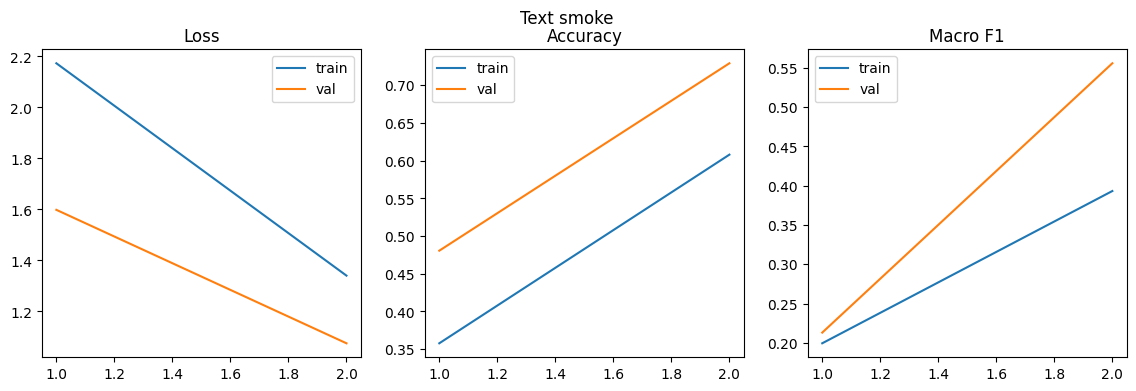

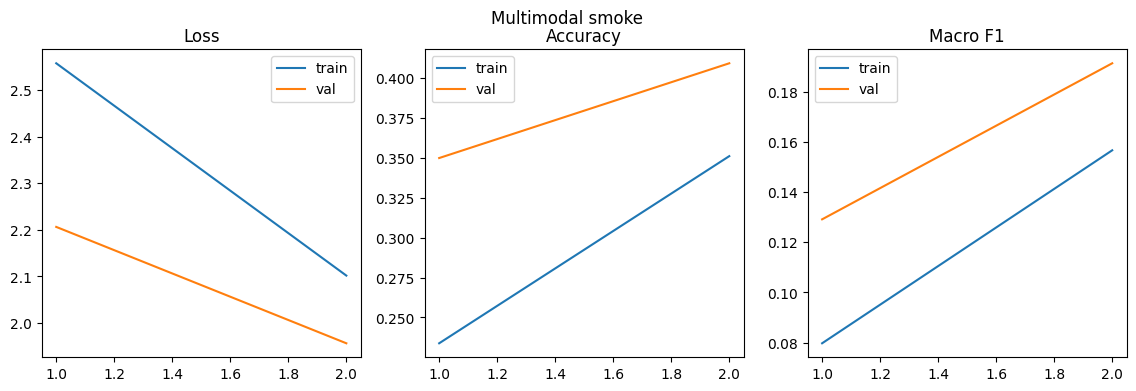

In [14]:
# Cell 13: Plot training curves for a single experiment
def plot_history(history, title="Experiment"):
    epochs = len(history["train_loss"])
    plt.figure(figsize=(14,4))
    plt.subplot(1,3,1)
    plt.plot(range(1, epochs+1), history["train_loss"], label="train")
    plt.plot(range(1, epochs+1), history["val_loss"], label="val")
    plt.title("Loss"); plt.legend()
    plt.subplot(1,3,2)
    plt.plot(range(1, epochs+1), history["train_acc"], label="train")
    plt.plot(range(1, epochs+1), history["val_acc"], label="val")
    plt.title("Accuracy"); plt.legend()
    plt.subplot(1,3,3)
    plt.plot(range(1, epochs+1), history["train_f1"], label="train")
    plt.plot(range(1, epochs+1), history["val_f1"], label="val")
    plt.title("Macro F1"); plt.legend()
    plt.suptitle(title)
    plt.show()

# Example: plot smoke test histories
plot_history(hist_text, title="Text smoke")
plot_history(hist_mm, title="Multimodal smoke")


Classification report:
                                 precision    recall  f1-score   support

                  air trapping       0.00      0.00      0.00        45
              alveolar pattern       0.00      0.00      0.00        29
          aortic atheromatosis       0.00      0.00      0.00        49
             aortic elongation       0.95      1.00      0.97        93
     apical pleural thickening       0.00      0.00      0.00        41
           callus rib fracture       0.00      0.00      0.00        21
                  cardiomegaly       0.39      0.78      0.52       100
               chronic changes       0.95      0.97      0.96        99
   costophrenic angle blunting       0.00      0.00      0.00        38
                 fibrotic band       0.00      0.00      0.00        30
             increased density       0.00      0.00      0.00        22
                   infiltrates       0.00      0.00      0.00        31
          interstitial pattern       0.

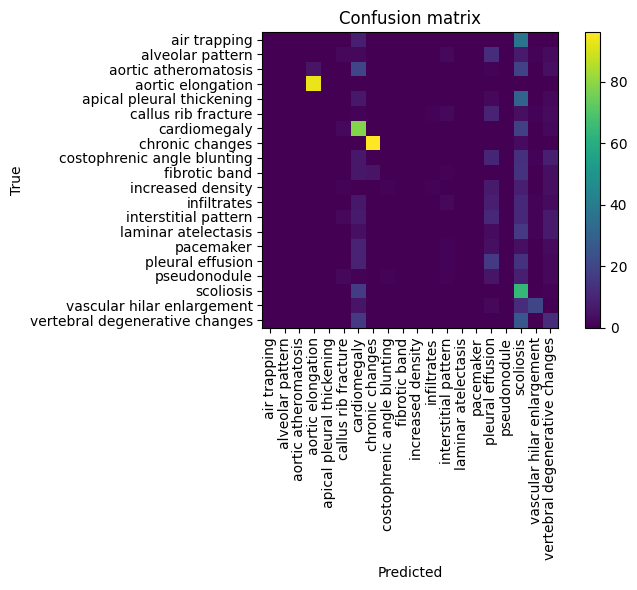

In [15]:
# Cell 14: Load best multimodal (or text) checkpoint and compute classification report/confusion matrix
# Replace "mm_smoke_best.pth" with a real checkpoint filename from `results` or smoke run.
ckpt_to_load = "mm_smoke_best.pth"  # example (change as needed)

# choose model class based on checkpoint naming (simple heuristic)
if "text" in ckpt_to_load:
    model = TextBiLSTM(vocab_size=vocab_size, emb_dim=128, hidden_dim=128, num_layers=1, num_classes=num_classes)
else:
    model = MultimodalEfficientNet(vocab_size=vocab_size, num_classes=num_classes)

model.load_state_dict(torch.load(ckpt_to_load, map_location=device))
model.to(device)
model.eval()

_, _, _, true_labels, pred_labels = validate_epoch(model, val_loader, nn.CrossEntropyLoss(), device)
print("Classification report:\n", classification_report(true_labels, pred_labels, target_names=le.classes_, zero_division=0))

# confusion matrix plot
cm = confusion_matrix(true_labels, pred_labels)
plt.figure(figsize=(8,6))
plt.imshow(cm, interpolation='nearest')
plt.title("Confusion matrix")
plt.colorbar()
tick_marks = np.arange(len(le.classes_))
plt.xticks(tick_marks, le.classes_, rotation=90)
plt.yticks(tick_marks, le.classes_)
plt.ylabel('True')
plt.xlabel('Predicted')
plt.tight_layout()
plt.show()
